# Optimizing circuits with the sequential optimization plugin

The sequential minimization optimization is a hybrid classical-quantum algorithm which leverages the parameter-shift rule to locally optimize the angles of a certain class of circuit with three energy measurements. 

This algorithm is described in [Nakanishi et al., (2020)](https://arxiv.org/abs/1903.12166) and [Ostaszewski et al., (2021)](https://arXiv.org/abs/1905.09692) (where it is called 'rotosolve').

It only applies to circuits whose parametrized gates are of the form $$G(\theta)=e^{-ic\theta/2\hat{P}}$$ where $\hat{P}$ is a tensor product of Pauli matrices and $c$ is a constant.

The algorithm provides local parameter updates by measuring the energy associated to symmetric shifts around the current value of the angle that is being optimized, and in the absence of any noise source it is completely deterministic.

This optimization algorithm has been implemented in the QLM as the `SeqOptim` plugin. The $c$ constant can be set using the `coeff` input of the plugin.

We compare the sequential optimization method of `SeqOptim` to the COBYLA method of the `ScipyMinimizePlugin`.

In general, the sequential algorithm is expected to perform better than COBYLA in presence of shot noise.

In [1]:
from collections import defaultdict
from itertools import product
import numpy as np
import matplotlib.pyplot as plt

from qat.qpus import LinAlg

from qat.fermion.transforms import transform_to_jw_basis
from qat.fermion.hamiltonians import make_embedded_model
from qat.fermion.circuits import make_shallow_circ, make_ldca_circ

from qat.plugins import ScipyMinimizePlugin, SeqOptim

## 1. Definition of the target Hamiltonian

We want to find the approximate ground state of a Hamiltonian describing a single impurity (onsite Coulomb repulsion $U=1$) coupled to a single bath level, which corresponds to 4-qubit circuits. We set $\mu=U/2$ to enforce half-filling, and consider the paramagnetic case.

In [2]:
U = 1
mu = U / 2
D = 0.4 * np.eye(2)
lambda_c = -0.04 * np.eye(2)
hamiltonian = make_embedded_model(U, mu, D, lambda_c, grouping="spins")

**Note**: the ordering of the orbitals, done via the grouping option `grouping="spins"`, is crucial for the hardware efficient ansatz circuit.

For assessing the plugin results later on, we compute the exact energy of the Hamiltonian ground state via direct diagonalization.

In [3]:
eigvals_cl = np.linalg.eigvalsh(hamiltonian.get_matrix())
E0 = min(eigvals_cl)
print(f"Exact ground state energy:\nE0 = {E0}")

Exact ground state energy:
E0 = -1.1286686816105571


## 2. Optimization of a small hardware-efficient ansatz circuit
We first run VQE on a circuit comprising only a few $CNOT$ gates. The parameters of the variational state are the angles of the $RY$ gates. Since the definition of a $RY$ gate is

$$ RY(\theta) = e^{-i\theta/2\hat{Y}} $$

we can optimize the variational angles of the circuit thanks to the sequential optimization plugin.

**Note**: The $c$ constant is here $c=1$. Since this is the default behaviour of the plugin, setting the `coeff` input when initializing `SeqOptim`is not needed. Here we do it anyway for comprehension purpose.

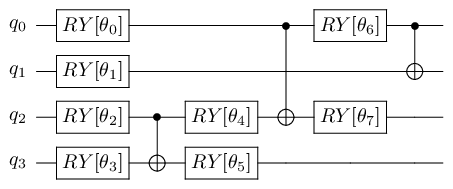

In [4]:
# Define a shallow circuit
circ = make_shallow_circ()
circ.display()

In [5]:
# Set the seed to ensure reproducibility of the results
np.random.seed(20)

# Define random initial parameters
x0 = np.random.random(len(circ.var_dic))
print(f"Initial parameters x0 = {x0}")

# Initialize the QPU
qpu = LinAlg()

# Initialize the stacks
stacks = {}

# COBYLA stack
scipy_optimizer = ScipyMinimizePlugin(x0=x0, method="COBYLA", tol=1e-3, options={"maxiter": 500})
stacks["cobyla"] = scipy_optimizer | qpu

# Sequential optimizer stack
sequential_optimizer = SeqOptim(x0=x0, ncycles=10, coeff=1.0)
stacks["seqoptim"] = sequential_optimizer | qpu

Initial parameters x0 = [0.5881308  0.89771373 0.89153073 0.81583748 0.03588959 0.69175758
 0.37868094 0.51851095]


We will compare the performance of the plugins for infinite shots and for 8192 shots. To do so, we define two jobs:

In [6]:
# Get the Hamiltonian in spin representation
hamiltonian_spin = transform_to_jw_basis(hamiltonian)

jobs = {
    "infinite_n_shots": circ.to_job(job_type="OBS", observable=hamiltonian_spin),
    "finite_n_shots": circ.to_job(job_type="OBS", observable=hamiltonian_spin, nbshots=8192),
}

We now submit the two jobs to the two stacks previously defined.

In [7]:
results = defaultdict(dict)

for job_name in jobs:
    for stack_name in stacks:

        # Get stack and job
        stack = stacks[stack_name]
        job = jobs[job_name]

        # Submit job to the stack
        result = stack.submit(job)
        results[stack_name][job_name] = eval(result.meta_data["optimization_trace"])

We plot the evolution of the variational energy during the optimization using the shallow circuit ansatz:

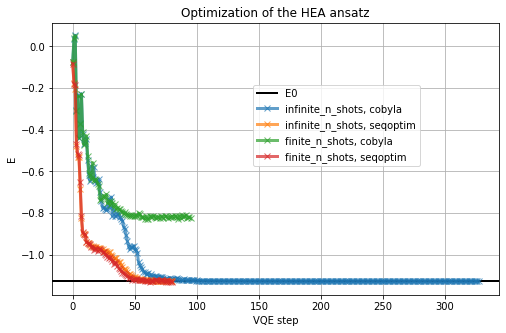

In [8]:
# Initialize figure and plot exact energy line
fig, ax = plt.subplots(figsize=((8, 5)))
ax.axhline(E0, lw=2, color="black", label="E0")

# Unpack and plot the optimization traces
for job_name in jobs:
    for stack_name in stacks:

        # In SeqOptim, only one measurement out of three is the energy
        step = 1 if stack_name == "cobyla" else 3

        ax.plot(results[stack_name][job_name][::step], "-x", label=f"{job_name}, {stack_name}", alpha=0.7, lw=3)

ax.grid()
ax.set_xlabel("VQE step")
ax.set_ylabel("E")
ax.set_title("Optimization of the HEA ansatz")
fig.legend(loc=(0.5, 0.5))

We can see that the energy converges much faster with `SeqOptim` than with `ScipyMinimizePlugin`'s COBYLA method. The number of shots does not significatively influence the results.

## 3. Optimization of the 1-cycle LDCA circuit

We now turn to a more complex optimization, using a physically-inspired ansatz circuit called the Low-Depth Circuit Ansatz (LDCA). Its tunable gates are two-qubits rotation gates which, when compiled into the native IBM gate set, are simply one-qubit Pauli rotation gates.

**Note** : To make these two-qubits gates QLM compatible, we need to set `coeff=0.5` in the `SeqOptim`plugin.

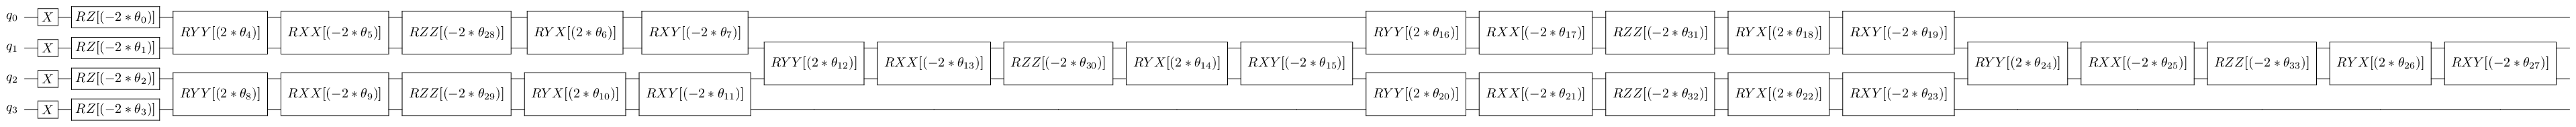

In [9]:
circ = make_ldca_circ(4, 1)
circ.display()

We now follow the same steps as previously:

In [10]:
# Define new random initial parameters
x0 = np.random.random(len(circ.var_dic))
print(f"Initial parameters x0 = {x0}")

# Update COBYLA stack
scipy_optimizer = ScipyMinimizePlugin(x0=x0, method="COBYLA", tol=1e-3, options={"maxiter": 500})
stacks["cobyla"] = scipy_optimizer | qpu

# Sequential optimizer stack
sequential_optimizer = SeqOptim(x0=x0, ncycles=10, coeff=0.5)
stacks["seqoptim"] = sequential_optimizer | qpu

Initial parameters x0 = [0.65795147 0.19385022 0.2723164  0.71860593 0.78300361 0.85032764
 0.77524489 0.03666431 0.11669374 0.7512807  0.23921822 0.25480601
 0.85762553 0.94977903 0.56168686 0.17878052 0.77025193 0.49238104
 0.63125307 0.83949792 0.4610394  0.49794007 0.67941112 0.65078591
 0.26879524 0.06732467 0.77144514 0.48098413 0.32920641 0.51064106
 0.26362883 0.31051155 0.62685344 0.55744981]


In [11]:
# Redefine the jobs with the LDCA circuit
jobs = {
    "infinite_n_shots": circ.to_job(job_type="OBS", observable=hamiltonian_spin),
    "finite_n_shots": circ.to_job(job_type="OBS", observable=hamiltonian_spin, nbshots=8192),
}

# Submit the jobs to the stacks
results = defaultdict(dict)

for job_name in jobs:
    for stack_name in stacks:

        # Get stack and job
        stack = stacks[stack_name]
        job = jobs[job_name]

        # Submit job to the stack
        result = stack.submit(job)
        results[stack_name][job_name] = eval(result.meta_data["optimization_trace"])

We plot the evolution of the variational energy during the optimization using the LDCA circuit ansatz:

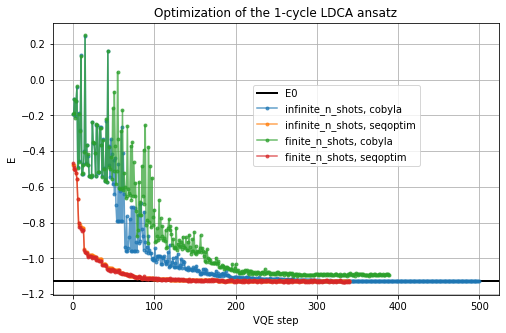

In [12]:
# Initialize figure and plot exact energy line
fig, ax = plt.subplots(figsize=((8, 5)))
ax.axhline(E0, lw=2, color="black", label="E0")

# Unpack and plot the optimization traces
for job_name in jobs:
    for stack_name in stacks:

        # In SeqOptim, only one measurement out of three is the energy
        step = 1 if stack_name == "cobyla" else 3

        ax.plot(results[stack_name][job_name][::step], ".-", label=f"{job_name}, {stack_name}", alpha=0.7)

ax.grid()
ax.set_xlabel("VQE step")
ax.set_ylabel("E")
ax.set_title("Optimization of the 1-cycle LDCA ansatz")
fig.legend(loc=(0.5, 0.5))

Again, the energy converges much faster with `SeqOptim` than with `ScipyMinimizePlugin`'s COBYLA method, while being les sensitive to shot noise.